<a href="https://colab.research.google.com/github/ParthShah412/HelloGit/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tests import test_prediction, test_generation
from torch.optim import Adam
import pdb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = ('cpu')
torch.cuda.empty_cache()

In [124]:
# load all that we need
print(device)
dataset = np.load('/content/handout/dataset/wiki.train.npy')
fixtures_pred = np.load('/content/handout/fixtures/prediction.npz')  # dev
fixtures_gen = np.load('/content/handout/fixtures/generation.npy')  # dev
fixtures_pred_test = np.load('/content/handout/fixtures/prediction_test.npz')  # test
fixtures_gen_test = np.load('/content/handout/fixtures/generation_test.npy')  # test
vocab = np.load('/content/handout/dataset/vocab.npy')

cuda


In [125]:
print(fixtures_pred['inp'][1])
print(fixtures_pred['out'][1])
strn = ' '.join(vocab[word] for word in fixtures_pred['inp'][1])
print(strn, vocab[fixtures_pred['out'][1]], vocab[24820])

[14658 21076 21626 31353  6613  1419 10706 15340 25874 25949 31994 21626
  2299  3952    79  1419    76  1184 31543  1242]
24820
a few from the Heavy <unk> Platoon and one or two from B Company . <unk> , 60 to 70 men men


In [0]:
# data loader

class LanguageModelDataLoader(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        # concatenate your articles and build into batches
        
        np.random.shuffle(self.dataset)
        shuffled_data = self.dataset
        concatenated_data = []
        for i in shuffled_data:
            concatenated_data.extend(i)
        concatenated_data = np.asarray(concatenated_data)
        new_len = concatenated_data.shape[0] - concatenated_data.shape[0]%self.batch_size
        temp_data = concatenated_data[:new_len]
        concatenated_data = temp_data.reshape(self.batch_size, temp_data.shape[0]//self.batch_size)
        seq_len = 0
        j = 0
        while(j<concatenated_data.shape[1]):
            tmp = np.random.randn(1)
            if(tmp > 0.05):
                seq_len = np.random.normal(70,5,1)
            else:
                seq_len = np.random.normal(35,5,1)
            if(j+seq_len<(concatenated_data.shape[1])):
                batch_arr = np.zeros((self.batch_size,int(seq_len)-1))
                batch_otp = np.zeros((self.batch_size,int(seq_len)-1))
                for i in range(concatenated_data.shape[0]-1):
                    batch_arr[i] = concatenated_data[i,j:j+int(seq_len)-1]
                    batch_otp[i] = concatenated_data[i,j+1:j+int(seq_len)]
                j = j+int(seq_len)
                yield (batch_arr, batch_otp)
            else:
                break
        
        

In [0]:
load_data = LanguageModelDataLoader(dataset,80)
k = 0
for i,(j,k) in enumerate(load_data):
    print(j.shape, k.shape)

In [0]:
# model

class LanguageModel(nn.Module):
    """
        TODO: Define your model here
    """
    def __init__(self, vocab_size, embed_size, hidden_size, nlayers):
        super(LanguageModel, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.nlayers=nlayers
        self.embedding = nn.Embedding(vocab_size,embed_size) # Embedding layer
        self.rnn = nn.LSTM(input_size = embed_size,hidden_size=hidden_size,num_layers=nlayers, bidirectional=True) # Recurrent network
        self.scoring = nn.Linear(2*hidden_size,vocab_size) # Projection layer

    def forward(self, x, hidden=None):
        batch_size = x.size(1)
        embeddings = self.embedding(x)
        output_lstm,hidden = self.rnn(embeddings, hidden)
        embeddings = embeddings.detach().cpu().numpy()
        del embeddings
        output_lstm_flatten = output_lstm.view(-1,2*self.hidden_size)
        output_flatten = self.scoring(output_lstm_flatten)
        output_lstm_flatten = output_lstm_flatten.detach().cpu().numpy()
        del output_lstm_flatten
        torch.cuda.empty_cache()
        return output_flatten.view(-1, batch_size, self.vocab_size), hidden
        
        

    


In [0]:
model = LanguageModel(vocab_size=len(vocab), embed_size=400, hidden_size = 1150, nlayers=3)
model.to(device)
for i,(j,k) in enumerate(load_data):
    inputs = torch.LongTensor(j).to(device)
    output = model(inputs)
    print(output.shape)
#     output = output.detach().cpu().numpy()
    inputs = inputs.detach().cpu().numpy()
    del output
    del inputs
    torch.cuda.empty_cache()

NameError: ignored

In [0]:
# model trainer

class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        # TODO: Define your optimizer and criterion here
        self.optimizer = Adam(model.parameters(), lr = 0.001)
        self.criterion = nn.CrossEntropyLoss()

    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        num_batches = 0
        for batch_num, (inputs, targets) in enumerate(self.loader):
            epoch_loss += self.train_batch(inputs, targets)
            print(epoch_loss)
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        self.optimizer.zero_grad()
        inputs = torch.LongTensor(inputs).to(device)
        inputs = torch.transpose(inputs,0,1).to(device)
        targets = torch.LongTensor(targets).to(device)
        targets = torch.transpose(targets,0,1).to(device)
        hidden = None
        outputs, hidden = model(inputs, hidden)
        targets = targets.contiguous()
        outputs = outputs.view(-1,outputs.size(2))
        loss = self.criterion(outputs, targets.view(-1))
        #loss = Variable(loss, requires_grad=True)
        loss.backward()
        self.optimizer.step()
        return loss
        

    
    def test(self):
        # don't change these
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generation(fixtures_gen, 10, self.model) # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model)
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, nll))
        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [0]:
class TestLanguageModel:
    def prediction(inp, model):
        with torch.no_grad():
            outputs_array = np.zeros((inp.shape[0],len(vocab)))
            inputs = torch.LongTensor(inp).to(device)
            inputs = torch.transpose(inputs,0,1)
            hidden=None
            outputs, hidden = model(inputs, hidden)
            outputs_array = outputs[-1,:,:].cpu().numpy()
            outputs_array = outputs_array.astype(np.float64)
        return outputs_array
            
    def generation(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """
        generated_output = []
        with torch.no_grad():
            inputs = torch.LongTensor(inp).to(device)
            inputs = torch.transpose(inputs,0,1)
            hidden = None
            outputs, hidden = model(inputs, hidden)
            temp = outputs[-1,:,:]
            _,current_word = torch.max(temp,dim=1)
            generated_output.append(current_word.cpu().numpy())
            for j in range(1,forward):
              word = current_word
              word = word.view(1,-1)
              output, hidden = model(word, hidden)
              _,current_word = torch.max(temp,dim=1)
              generated_output.append(current_word.cpu().numpy())
        generated_matrix = np.asarray(generated_output)
        print(generated_matrix.shape)
        return generated_matrix.T


In [0]:
# TODO: define other hyperparameters here

NUM_EPOCHS = 8
BATCH_SIZE = 80


In [137]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1555388894


In [0]:
model = LanguageModel(vocab_size=len(vocab), embed_size=400, hidden_size = 1150, nlayers=3)
model.to(device)
loader = LanguageModelDataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id)


In [0]:
best_nll = 1e30
for epoch in range(NUM_EPOCHS):
  nll = trainer.test()
  if nll < best_nll:
    best_nll = nll
    print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))

(10, 32)
(10, 128)
[VAL]  Epoch [1/8]   Loss: 10.4125
Saving model, predictions and generated output for epoch 0 with NLL: 10.412534264643355
(10, 32)
(10, 128)
[VAL]  Epoch [1/8]   Loss: 10.4125
(10, 32)
(10, 128)
[VAL]  Epoch [1/8]   Loss: 10.4125
(10, 32)
(10, 128)
[VAL]  Epoch [1/8]   Loss: 10.4125
(10, 32)
(10, 128)
[VAL]  Epoch [1/8]   Loss: 10.4125
(10, 32)
(10, 128)
[VAL]  Epoch [1/8]   Loss: 10.4125
(10, 32)
(10, 128)
[VAL]  Epoch [1/8]   Loss: 10.4125
(10, 32)
(10, 128)
[VAL]  Epoch [1/8]   Loss: 10.4125


In [139]:
best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        trainer.save()
    

tensor(10.4114, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20.6574, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.5937, device='cuda:0', grad_fn=<AddBackward0>)
tensor(38.2340, device='cuda:0', grad_fn=<AddBackward0>)
tensor(45.7019, device='cuda:0', grad_fn=<AddBackward0>)
tensor(53.1478, device='cuda:0', grad_fn=<AddBackward0>)
tensor(60.6593, device='cuda:0', grad_fn=<AddBackward0>)
[TRAIN]  Epoch [2/8]   Loss: 8.6656
(10, 32)
(10, 128)
[VAL]  Epoch [2/8]   Loss: 7.7256
Saving model, predictions and generated output for epoch 0 with NLL: 7.725634237300708
tensor(7.1216, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.1562, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.3414, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.5622, device='cuda:0', grad_fn=<AddBackward0>)
tensor(35.8204, device='cuda:0', grad_fn=<AddBackward0>)
tensor(43.1740, device='cuda:0', grad_fn=<AddBackward0>)
[TRAIN]  Epoch [3/8]   Loss: 7.1957
(10, 32)
(10, 128)
[VAL]  Epoch [3/8]   Loss: 7.

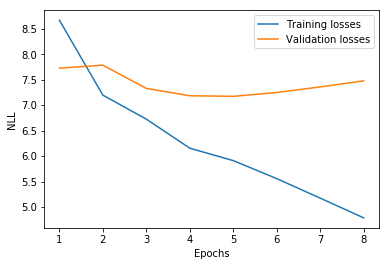

In [140]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [141]:
# see generated output
print (trainer.generated[-1]) # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | a a a a a a a a a a
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | in in in in in in in in in in
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | @-@ @-@ @-@ @-@ @-@ @-@ @-@ @-@ @-@ @-@
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | and and and and and and and and and and
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | . . . . . . . . . .
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | @-@ @-@ @-@ @-@ @-@ @-@ @-@ @-@ @-@ @-@
Input | Output #6: <unk> , $ 96 million USD ) . Damage was heaviest in South Korea , notably where it moved 